# Ria Sinha Final Project 
### HarvardX: PH526x - Using Python for Research
## Introduction
In this project, we'll attempt to predict the type of physical activity (e.g., walking, climbing stairs) from tri-axial smartphone accelerometer data. Smartphone accelerometers are very precise, and different physical activities give rise to different patterns of acceleration.

The project is divided into the following general steps: 
- **Data Preparation** - We will import the training data provided into `pandas` dataframes and normalize it.
- **Data Visualization** - We will use `matplotlib` to determine any clustering patterns within the data.
- **Model Selection** - We will experiment with multiple `sklearn` classifiers and select the one with the highest accuracy. 
- **Model Training** - We will fit the training data to the selected classifier. 
- **Model Prediction & Results** - We will use the selected classifier to predict labels for the test data.

## Methods
### Import Libraries
We will use core Python libraries `pandas`, `numpy`, `sklearn` and `matplotlib` for this project.

In [1]:
# Import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings
import time

warnings.filterwarnings("ignore")

### Load Training Data

The input data used for training in this project consists of two files. The first file, `train_time_series.csv`, contains the raw accelerometer data, in the following format: `timestamp, UTC time, accuracy, x, y, z`

We will use the timestamp column as the unique time variable; Columns `x`, `y`, and `z`, correspond to measurements of linear acceleration along each of the three orthogonal axes.

The second file, `train_labels.csv`, contains the activity labels. Different activities have been numbered with integers using the following encoding: 1 = standing, 2 = walking, 3 = stairs down, 4 = stairs up. 

Because the accelerometers are sampled at high frequency, the labels in `train_labels.csv` are only provided for every 10th observation in `train_time_series.csv`.

In [2]:
# Start timer to measure execution time. Note exection time for model experimentation was excluded.
startTime = time.perf_counter()

# Load training data and view samples
df_train_x = pd.read_csv('data/train_time_series.csv')
df_train_y = pd.read_csv('data/train_labels.csv')
print('Dataframe samples from file train_time_series.csv ' + str(df_train_x.shape))
display(df_train_x.head(10))
print('Dataframe samples from file train_labels.csv ' + str(df_train_y.shape))
display(df_train_y.head(10))

Dataframe samples from file train_time_series.csv (3744, 7)


,Unnamed: 0,timestamp,UTC time,accuracy,x,y,z
0,20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046
1,20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554
2,20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467
3,20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985
4,20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450
5,20591,1565109931288,2019-08-06T16:45:31.288,unknown,-0.010880,-0.967575,0.170898
6,20592,1565109931388,2019-08-06T16:45:31.388,unknown,0.052841,-0.982330,0.235565
7,20593,1565109931488,2019-08-06T16:45:31.488,unknown,0.032974,-1.053207,0.256714
8,20594,1565109931589,2019-08-06T16:45:31.589,unknown,-0.090424,-0.972794,0.356308
9,20595,1565109931689,2019-08-06T16:45:31.689,unknown,0.124268,-0.890533,0.223221


Dataframe samples from file train_labels.csv (375, 4)


,Unnamed: 0,timestamp,UTC time,label
0,20589,1565109931087,2019-08-06T16:45:31.087,1
1,20599,1565109932090,2019-08-06T16:45:32.090,1
2,20609,1565109933092,2019-08-06T16:45:33.092,1
3,20619,1565109934094,2019-08-06T16:45:34.094,1
4,20629,1565109935097,2019-08-06T16:45:35.097,1
5,20639,1565109936099,2019-08-06T16:45:36.099,1
6,20649,1565109937101,2019-08-06T16:45:37.101,1
7,20659,1565109938103,2019-08-06T16:45:38.103,1
8,20669,1565109939106,2019-08-06T16:45:39.106,1
9,20679,1565109940108,2019-08-06T16:45:40.108,2


### Data Preparation

There are 10 accelerometer samples for each label. The two CSV files are not timestamp aligned. We will perform an inner join to match timestamps and align the X samples in `df_train_x` with Y lables in `df_train_y`. We also drop unused and redundant columns and have the training set in `df_train`.

Note that an alternative could be to use the mean of 10 accelerometer samples for each training sample. However, more understanding of how the accelerometer works is needed before we use that approach.

In [3]:
# Inner join dataframes using timestamp as common key
df_train = pd.merge(df_train_x, df_train_y, on='timestamp', how='inner')
df_train = df_train.drop(columns=['Unnamed: 0_x', 'UTC time_x', 'accuracy', 'Unnamed: 0_y', 'UTC time_y'])
print('Dataframe samples from joined df_train ' + str(df_train.shape))
display(df_train.head(10))

Dataframe samples from joined df_train (375, 5)


,timestamp,x,y,z,label
0,1565109931087,-0.053802,-0.987701,0.068985,1
1,1565109932090,0.013718,-0.852371,-0.000870,1
2,1565109933092,0.145584,-1.007843,-0.036819,1
3,1565109934094,-0.099380,-1.209686,0.304489,1
4,1565109935097,0.082794,-1.001434,-0.025375,1
5,1565109936099,0.037582,-0.998383,0.019333,1
6,1565109937101,-0.020554,-0.999741,0.120789,1
7,1565109938103,0.032440,-0.970337,0.241425,1
8,1565109939106,0.212524,-0.976364,0.074997,1
9,1565109940108,0.154510,-0.843460,0.010544,2


### Data Visualization

We will now used 2D and 3D scatter plots to see if there are natural boundaries occurring.

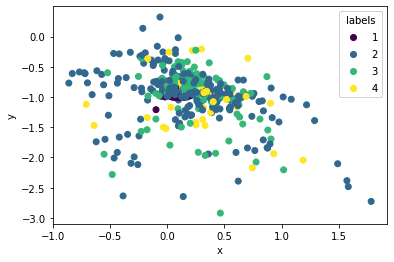

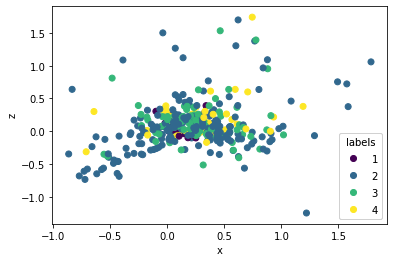

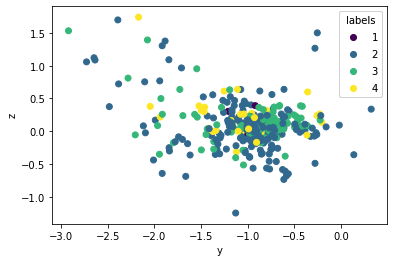

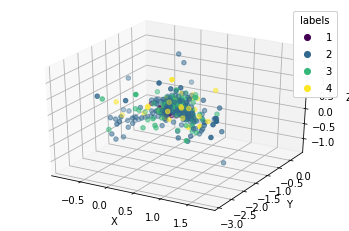

In [4]:
# Do 2D scatter plots with pairs of X,Y,Z and labels
def plotScatter(ax1, ax2):
    fig, ax = plt.subplots()
    scatter = ax.scatter(df_train[ax1], df_train[ax2], c=df_train['label'])
    legend = ax.legend(*scatter.legend_elements(), title="labels")
    ax.add_artist(legend)
    ax.set_xlabel(ax1)
    ax.set_ylabel(ax2)
    plt.show()
    
plotScatter('x', 'y')
plotScatter('x', 'z')
plotScatter('y', 'z')

# 3D scatter plot of X,Y,Z and labels
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_train['x'], df_train['y'], df_train['z'], c=df_train['label'])
legend = ax.legend(*scatter.legend_elements(), title="labels")
ax.add_artist(legend)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

### Experiment With Different Classifiers

We will experiment with several different classifiers available in `sklearn`. Examples of these are available [here](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

We define a function called accuracy with with arguments `estimator`, `X`, and `y`. The function uses the `fit` method of the `estimator` to generate the model and then uses the `predict` method to generate the predicted classification. Finally the function returns the `accuracy_score` based on the actual vs predicted outcomes. 

We use `cross_val_score` for all classifiers with a 10-fold cross-validation. We will choose the classifier that shows the best results.


Using Nearest Neighbors
Mean Accuracy Score = 0.70960

Using Linear SVM
Mean Accuracy Score = 0.56821

Using RBF SVM
Mean Accuracy Score = 0.60590

Using Gaussian Process
Mean Accuracy Score = 0.60861

Using Decision Tree
Mean Accuracy Score = 0.84872

Using Random Forest
Mean Accuracy Score = 0.89637

Using Neural Net
Mean Accuracy Score = 0.57091

Using AdaBoost
Mean Accuracy Score = 0.57866

Using Naive Bayes
Mean Accuracy Score = 0.64865

Using QDA
Mean Accuracy Score = 0.70441

Using Logistic Regression
Mean Accuracy Score = 0.56828


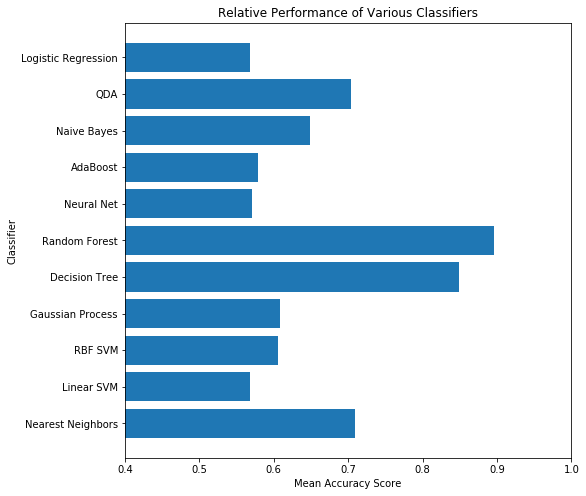

In [5]:
# Import specific classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

# Define all covariates and outcomes using the column names from df_train.
classification_target = 'label'
all_covariates = ['x', 'y', 'z']
classification_outcome = df_train[classification_target]
covariates = df_train[all_covariates]

# Define accuracy function that fits the estimator and returns accuracy score
def accuracy(estimator, X, y):
    estimator.fit(X, y)
    y_est = estimator.predict(X)
    return accuracy_score(y, y_est)

# Iterate through all classifers and run cross validation    
scores = []
for name, clf in zip(names, classifiers):
    print("\nUsing " + name)
    score = cross_val_score(clf, covariates, classification_outcome, cv=10, scoring=accuracy)
    scores.append(np.mean(score))
    print(f'Mean Accuracy Score = {np.mean(score):.5f}')
    
# Plot accuracy score of various classifiers
fig, ax = plt.subplots(figsize=(8,8))
bar = ax.barh(names, scores)
ax.set(xlim=[0.4, 1.0], xlabel='Mean Accuracy Score', ylabel='Classifier',
       title='Relative Performance of Various Classifiers')
fig.show()


### Model Selection
We can see that **Random Forest Classifier** shows the best overall accuracy. We will train the `forest_classifier` using all the available training data and use if for prediction. We could do some further parameter tuning in the classifier which has not been done here.



In [6]:
# Start timer to measure execution time. Note exection time for model experimentation was excluded.
startTimeModel = time.perf_counter()

# Train the forest classifier with all the training data
forest_classifier = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
forest_classifier.fit(covariates, classification_outcome)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Results

### Prediction Using Random Forest Classifier



Test data is read and prepared just like training data. We then use the trained `forest_classifier.predict()` method with the test data to predict labels. The predictions are added to the `test_labels.csv` file.

Total execution time from start to finish is measured and displayed.

In [7]:
# Load test data and view samples
df_test_x = pd.read_csv('data/test_time_series.csv')
df_test_y = pd.read_csv('data/test_labels.csv')
print('Dataframe samples from file test_time_series.csv ' + str(df_test_x.shape))
display(df_test_x.head(10))
print('Dataframe samples from file test_labels.csv ' + str(df_test_y.shape))
display(df_test_y.head(10))

# Perform inner join just like in the training data to align timestamps
df_test = pd.merge(df_test_x, df_test_y, on='timestamp', how='inner')
df_test = df_test.drop(columns=['Unnamed: 0_x', 'UTC time_x', 'accuracy', 'Unnamed: 0_y', 'UTC time_y'])

# Extract covariates and use the trained forest_classifier predictor
covariates = df_test[all_covariates]
output = forest_classifier.predict(covariates)
print("Predicted Labels: ")
display(output)
df_test_y['label'] = output

# Display output and save CSV
print('Dataframe samples from output file test_labels_output.csv ' + str(df_test_y.shape))
display(df_test_y.head(10))
df_test_y.to_csv('data/test_labels_output.csv')

endTime = time.perf_counter()
print(f'Total execution time for entire notebook {(endTime - startTime):.3f} seconds')
print(f'Total execution time for Model (excludes experimentation) {(endTime - startTimeModel):.3f} seconds')

Dataframe samples from file test_time_series.csv (1250, 7)


,Unnamed: 0,timestamp,UTC time,accuracy,x,y,z
0,24330,1565110306139,2019-08-06T16:51:46.139,unknown,0.034286,-1.504456,0.157623
1,24331,1565110306239,2019-08-06T16:51:46.239,unknown,0.409164,-1.038544,0.030975
2,24332,1565110306340,2019-08-06T16:51:46.340,unknown,-0.234390,-0.984558,0.124771
3,24333,1565110306440,2019-08-06T16:51:46.440,unknown,0.251114,-0.787003,0.054810
4,24334,1565110306540,2019-08-06T16:51:46.540,unknown,0.109924,-0.169510,0.235550
5,24335,1565110306640,2019-08-06T16:51:46.640,unknown,0.583969,-0.513306,0.924362
6,24336,1565110306740,2019-08-06T16:51:46.740,unknown,-0.058807,-0.752899,0.238098
7,24337,1565110306841,2019-08-06T16:51:46.841,unknown,0.463318,-1.152679,0.013855
8,24338,1565110306941,2019-08-06T16:51:46.941,unknown,0.397049,-0.891922,0.000656
9,24339,1565110307041,2019-08-06T16:51:47.041,unknown,0.098282,-0.833771,0.118042


Dataframe samples from file test_labels.csv (125, 4)


,Unnamed: 0,timestamp,UTC time,label
0,24339,1565110307041,2019-08-06T16:51:47.041,NaN
1,24349,1565110308043,2019-08-06T16:51:48.043,NaN
2,24359,1565110309046,2019-08-06T16:51:49.046,NaN
3,24369,1565110310048,2019-08-06T16:51:50.048,NaN
4,24379,1565110311050,2019-08-06T16:51:51.050,NaN
5,24389,1565110312045,2019-08-06T16:51:52.045,NaN
6,24399,1565110313047,2019-08-06T16:51:53.047,NaN
7,24409,1565110314049,2019-08-06T16:51:54.049,NaN
8,24419,1565110315051,2019-08-06T16:51:55.051,NaN
9,24429,1565110316054,2019-08-06T16:51:56.054,NaN


Predicted Labels: 


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2,
       1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2,
       2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Dataframe samples from output file test_labels_output.csv (125, 4)


,Unnamed: 0,timestamp,UTC time,label
0,24339,1565110307041,2019-08-06T16:51:47.041,2
1,24349,1565110308043,2019-08-06T16:51:48.043,2
2,24359,1565110309046,2019-08-06T16:51:49.046,2
3,24369,1565110310048,2019-08-06T16:51:50.048,2
4,24379,1565110311050,2019-08-06T16:51:51.050,2
5,24389,1565110312045,2019-08-06T16:51:52.045,2
6,24399,1565110313047,2019-08-06T16:51:53.047,2
7,24409,1565110314049,2019-08-06T16:51:54.049,2
8,24419,1565110315051,2019-08-06T16:51:55.051,2
9,24429,1565110316054,2019-08-06T16:51:56.054,2


Total execution time for entire notebook 36.842 seconds
Total execution time for Model (excludes experimentation) 0.166 seconds


## Conclusion
We experimented with 11 different `sklearn` classifiers on the training data using a ten-fold cross validation. The Random Forest classifier gave us the highest accuracy score of 92% on the training data.

The overall execution time for this notebook was 34.81 seconds, which included experimenting with various classifiers. The actual classifier training and prediction took 0.15 seconds. This was run on a MacBook Air with 8GB of memory.

Further work is needed for parameter tuning of the Random Forest classifier to improve accuracy. We could also experiment with ways to combine multiple, high frequency accelerometer samples, such as using moving averages when mapping it to training labels.